In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys 
import pickle

sys.path.append('../')
import torch
from torch.utils.data import Dataset, DataLoader
from src.config.config import cfg
from src.data.bengali_data import BengaliDataBatchCollator, BengaliDataset

In [3]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

In [4]:
train_path = cfg.DATASET.TRAIN_DATA_PATH
val_path = cfg.DATASET.VAL_DATA_PATH

In [5]:
# DATA LOADER
val_data = pickle.load(open(train_path, 'rb'))
val_dataset = BengaliDataset(val_data, cfg.DATASET, True)

In [6]:
collator = BengaliDataBatchCollator()
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collator, num_workers=1)

In [7]:
itr = iter(val_loader)

In [79]:
mean = [0.4, 0.2, 0.3]
a = torch.randn((16,3,128,128))
a.shape

torch.Size([16, 3, 128, 128])

In [83]:
a.mean(1)[:,None,:,:][1]

tensor([[[ 0.1126, -0.5542, -0.4357,  ..., -0.2591, -1.4548,  1.4228],
         [ 0.7388, -0.3138, -0.0746,  ...,  1.0959, -0.8672, -0.6673],
         [ 0.2126,  0.3141, -0.6449,  ..., -0.0196, -0.3018, -0.9997],
         ...,
         [-0.4735, -0.3893,  0.4895,  ..., -0.1700, -0.0162,  0.4184],
         [-0.6458,  0.3566,  0.6127,  ..., -0.5565, -0.1463, -0.3117],
         [-0.2381, -0.6224,  0.0523,  ..., -0.2834,  0.8213, -0.7559]]])

In [11]:
import time
s = time.time()
for i in range(500):
    _ = next(itr)
t = time.time()
print(t-s)

17.256835222244263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 128, 128])
torch.Size([3, 1, 1])
torch.Size([3, 128, 128])
tensor([[[1.3114, 1.3234, 1.2898],
         [1.3114, 1.3234, 1.2898],
         [1.2782, 1.2915, 1.2615],
         ...,
         [1.2782, 1.2915, 1.2615],
         [1.3197, 1.3314, 1.2968],
         [1.2865, 1.2995, 1.2685]],

        [[1.3114, 1.3234, 1.2898],
         [1.3114, 1.3234, 1.2898],
         [1.2533, 1.2676, 1.2402],
         ...,
         [1.2865, 1.2995, 1.2685],
         [1.3114, 1.3234, 1.2898],
         [1.3031, 1.3155, 1.2827]],

        [[1.3114, 1.3234, 1.2898],
         [1.3114, 1.3234, 1.2898],
         [1.2865, 1.2995, 1.2685],
         ...,
         [1.2865, 1.2995, 1.2685],
         [1.3114, 1.3234, 1.2898],
         [1.3031, 1.3155, 1.2827]],

        ...,

        [[1.3114, 1.3234, 1.2898],
         [1.3197, 1.3314, 1.2968],
         [1.3197, 1.3314, 1.2968],
         ...,
         [1.2948, 1.3075, 1.2756],
         [1.3114, 1.3234, 1.2898],
         [1.3197, 1.3314, 1.2968]],

    

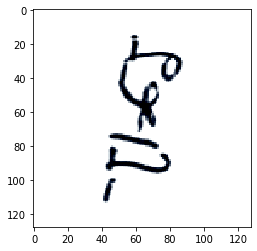

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
for i, (xb, yb) in enumerate(itr):
    if i == 5:
        print(xb.shape)
        mean=[0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        std = torch.FloatTensor(std).view(3,1,1)
        mt = torch.FloatTensor(mean).view(3,1,1)
        img = xb[0]
        print(mt.shape)
        print(img.shape)
        img *= mt
        img += std
        img = img.permute(2, 1, 0)
        print(img)
        plt.imshow(img)
#         print(img.shape)
#         print(inputs[0].shape)
        #im = Image.fromarray(img.cpu().detach().numpy())
#         #im = im.convert('RGB')
#         im.save("non_mixup_image.PNG")
        break

Wall time: 0 ns


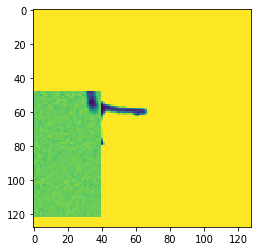

In [29]:
import matplotlib.pyplot as plt
%time 
for i, (xb, yb) in enumerate(itr):   
    #xb, yb = xb.to(device), yb = yb.to(device)
    
    xb, yb = cutmix(xb, yb[:,0], yb[:,1], yb[:,2], 1)
    
    plt.imshow(xb[1][2])
    
    if i == 1: break